假設今天有一個不成材的模型，怎麼訓練，怎麼漏洞百出。對於這種狀況，我們通常跟他說:一次無會，就多學幾次。這就是Adaboost Algorithm的原理。其步驟如下:

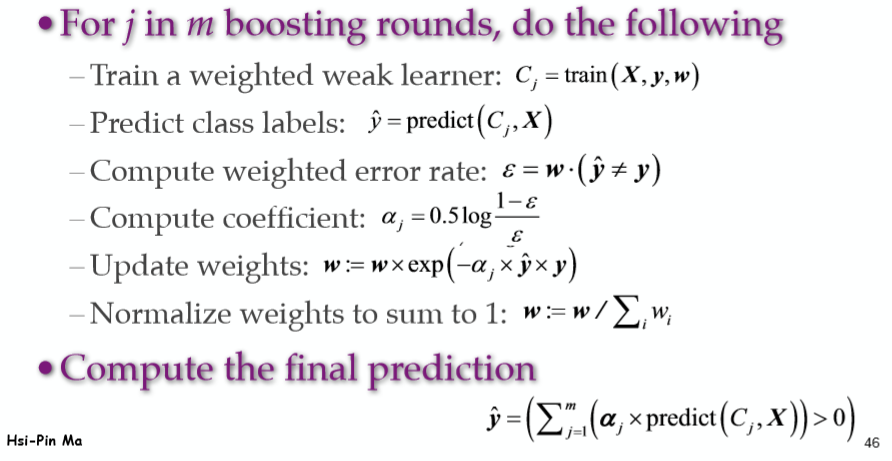

In [1]:
from IPython.display import Image
Image(filename='adaboost.png', width=500) 

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 這裡做的事情跟Ch4 ch5一模一樣
df_wine = pd.read_csv('wine.data', header=None) # open the wine dataset

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

從Adaboost的原理我們可以知道他需要先根據一個學習器做為標準。在這裡，我們先種一棵decicion tree，它的深度只有一層(夠弱了吧)。然後我們逼著他學500次(用500顆合成adaboost分類器)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1, #深度只有一層
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, # 500顆
                         learning_rate=0.1,
                         random_state=1)

In [5]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


Adaboost可以完美預測所有訓練數據樣本，對於測試數據集也有很好的預測率。然而，\textbf{兩者之間的差距卻大於單一一顆樹}，這是因為為了降低偏誤，模型反而會產生額外的偏誤。

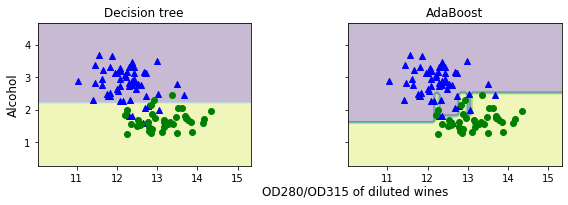

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
#plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

其實Adaboost跟裝袋法其實正確率是差不多的。但有一點必須注意:\textbf{使用相同的測試數據來選擇模型，是一種很不好的做法}。理由如第六章所述。